In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [7]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
!pip install scikit-plot -q
from scikitplot.metrics import plot_confusion_matrix

The dataset I am using --> [here](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

In [8]:
df_train = pd.read_csv("/content/train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("/content/val.txt",delimiter=';',names=['text','label'])

In [9]:
df_train.shape, df_val.shape

((16000, 2), (2000, 2))

In [22]:
df = pd.concat([df_train, df_val])
df.reset_index(inplace=True, drop=True)

In [23]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [24]:
try:
  sns.countplot(df.label)
except Exception as e:
  print('error - ', e)

error -  could not convert string to float: 'sadness'


In [25]:
df.label.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

<Axes: xlabel='label', ylabel='count'>

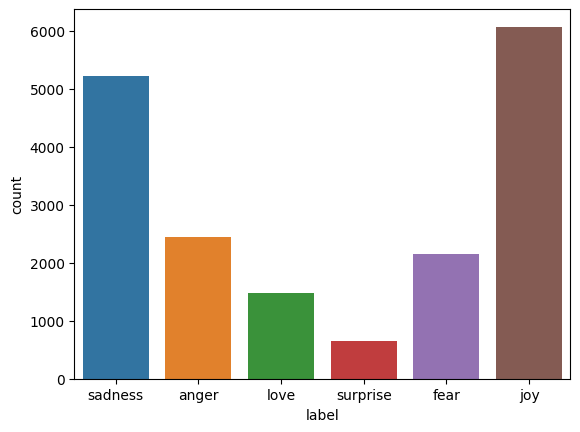

In [26]:
sns.countplot(df, x='label')

In [27]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [28]:
custom_encoder(df)

<Axes: xlabel='label', ylabel='count'>

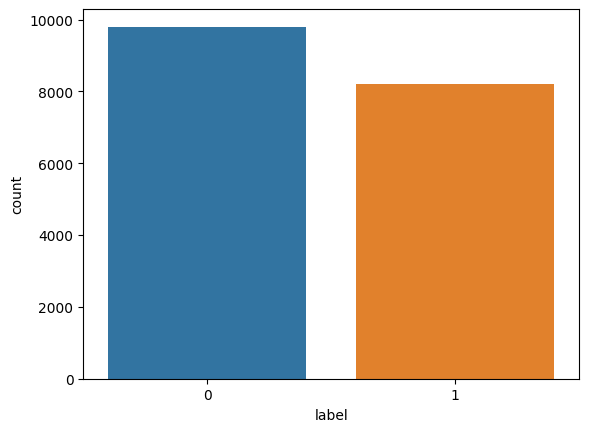

In [29]:
sns.countplot(df, x='label')

In [19]:
df.label.unique()

array([0, 1])

preprocessing

In [34]:
def text_transformation(df_col):
  lm  = WordNetLemmatizer()
  corpus = []
  for i in df_col:
    new_item = re.sub('[^a-zA-Z]', ' ', str(i)) # taking only characters
    new_item = new_item.lower()   # lowering the text
    new_item = new_item.split()   # splitting the text into words
    # lemmatize with remove stop words
    new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
    corpus.append(' '.join(str(x) for x in new_item)) # back to sentence
  return corpus

corpus = text_transformation(df['text'])

In [35]:
corpus[:5]

['didnt feel humiliated',
 'go feeling hopeless damned hopeful around someone care awake',
 'im grabbing minute post feel greedy wrong',
 'ever feeling nostalgic fireplace know still property',
 'feeling grouchy']

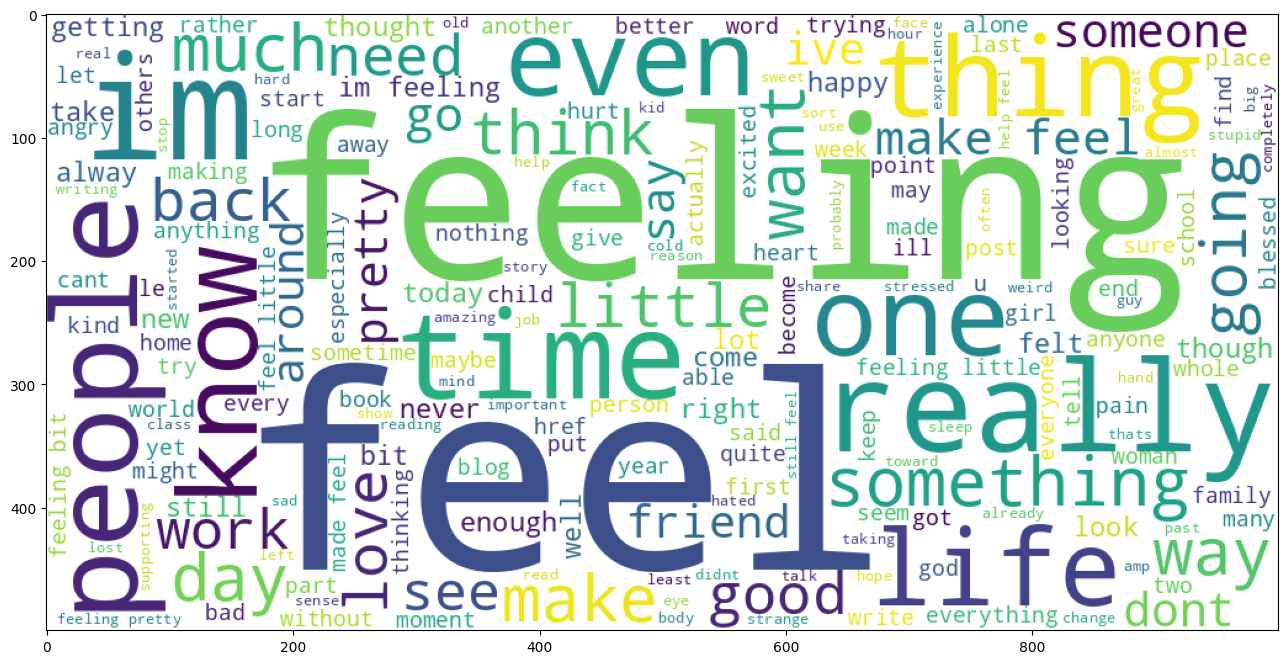

In [38]:
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)

In [42]:
cv = TfidfVectorizer()
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

In [43]:
traindata.shape

(18000, 14295)

In [55]:
parameters = {'alpha':[1,2,3,4,5],
              'fit_prior': [True, False],}

grid_search = GridSearchCV(MultinomialNB(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

{'alpha': 2, 'fit_prior': False}

In [57]:
model = MultinomialNB(alpha=grid_search.best_params_['alpha'],
                               fit_prior=grid_search.best_params_['fit_prior'],)
model.fit(X,y)

MultinomialNB(alpha=2, fit_prior=False)

In [58]:
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

In [59]:
X_test,y_test = df_val.text,df_val.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = model.predict(testdata)

Accuracy_score:  0.9665
Precision_score:  0.9880174291938998
Recall_score:  0.9418483904465212
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1037
           1       0.99      0.94      0.96       963

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



<Figure size 1000x1500 with 0 Axes>

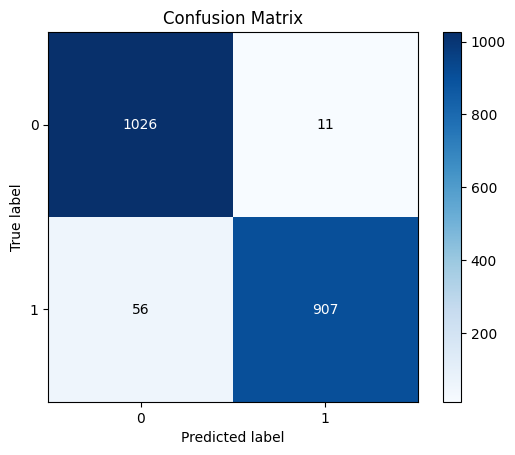

In [60]:
plt.figure(figsize=(10, 15))
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

In [61]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = model.predict(transformed_input)
    expression_check(prediction)

In [62]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]

sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
